# Session 3 — Sentence-Level Analysis
## Measure 4: Clause Density / Subordination

Long sentences are not always complex, sometimes they are just lists. Clause density (how many finite verbs or subordinating markers per sentence) is another proxy for complexity.

**What is a clause?**
A clause is a unit of grammar containing a subject and a predicate (verb). There are two main types:
- **Independent clause**: Can stand alone as a complete sentence (e.g., "Alice fell down the rabbit hole")
- **Subordinate clause**: Cannot stand alone and depends on the main clause (e.g., "when she saw the White Rabbit")

**Why measure clause density?**
- **Syntactic complexity**: More subordinate clauses = more complex sentence structure
- **Cognitive load**: Sentences with multiple embedded clauses are harder to process
- **Writing maturity**: Advanced writers tend to use more subordination to express nuanced relationships between ideas
- **Genre differences**: Academic writing typically has higher clause density than fiction

**How we measure it:**
We count subordinating conjunctions and relative pronouns (that, which, who, when, where, because, although, if, while, etc.) as proxies for subordinate clauses. Each marker typically introduces a dependent clause that adds information to the main clause.

This notebook:
- splits into sentences
- counts clause-like elements using regex for conjunctions (that, which, because, when, if, while, etc.)
- computes clauses per sentence

We'll analyze Lewis Carroll's two Alice books to compare their syntactic complexity.

In [1]:
import re, os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set plot styles
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# --- Configuration ---
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
    "book1_name": "Fellowship",
    "book2_name": "Two Towers",
    "book3_name": "Return of the King",
}
# Create results directory
Path("../results").mkdir(exist_ok=True)

# Define clause markers (subordinating conjunctions and relative pronouns)
CLAUSE_MARKERS = r'\b(that|which|who|whom|whose|where|when|while|if|because|although|though|unless|until|since|before|after|as)\b'

# --- Robust Text Loading Functions (from our previous projects) ---
_GB_START_MARKERS = [r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK", r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",]
_GB_END_MARKERS = [r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK", r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",]
_CHAPTER_HINTS = [
    r"^\s*A LONG-EXPECTED PARTY\s*$", # Start of Fellowship
    r"^\s*The Departure of Boromir\s*$", # Start of Two Towers
    r"^\s*Minas Tirith\s*$", # Start of Return of King
    r"^\s*CHAPTER I\s*$",
    r"^\s*BOOK I\s*$",
]

def strip_gutenberg(text: str) -> str:
    """Heuristically strips Gutenberg headers/footers."""
    t = text.replace("\ufeff", "") 
    start_idx, end_idx = None, None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1: start_idx = m.end()
            break
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else: 
        core = t
        found_start = False
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m: 
                core = core[m.start():]
                found_start = True
                break
        if found_start:
            for pat in _GB_END_MARKERS:
                 m = re.search(pat, core, flags=re.IGNORECASE)
                 if m:
                     core = core[:m.start()]
                     break
    return core.strip()

def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    """Cleans text: strips Gutenberg, normalizes whitespace."""
    t = strip_gutenberg(t)
    # Replace line breaks with spaces, then collapse whitespace
    t = re.sub(r"[\r\n]+", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t

print("Cell 1: Setup and robust loading functions defined.")

Cell 1: Setup and robust loading functions defined.


In [2]:
# Load and normalize all three texts
print("Loading and cleaning texts...")
text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

print(f"{CONFIG['book1_name']} loaded: {len(text1):,} characters")
print(f"{CONFIG['book2_name']} loaded: {len(text2):,} characters")
print(f"{CONFIG['book3_name']} loaded: {len(text3):,} characters")

def analyze_clause_density(text, book_name, show_examples=5):
    """Analyze clause density in the text"""
    # Split into sentences
    sentences = re.split(r'[.!?]+\s+', text.strip())
    sentences = [s.strip() for s in sentences if s.strip() and len(s.split()) > 2]
    
    if not sentences:
        print(f"ERROR: No sentences found for {book_name}. Check stripping.")
        return [], [], 0, 0
    
    clause_counts = []
    clause_densities = []
    
    for s in sentences:
        # Count clause markers (using CLAUSE_MARKERS defined in Cell 1)
        num_markers = len(re.findall(CLAUSE_MARKERS, s, flags=re.IGNORECASE))
        # Heuristic: Total clauses = (1 Base Clause) + (Number of Subordinate Markers)
        clauses = 1 + num_markers 
        tokens = len(s.split())
        density = clauses / (tokens / 10) if tokens > 0 else 0
        
        clause_counts.append(clauses)
        clause_densities.append(density)
    
    avg_clauses = sum(clause_counts) / len(clause_counts)
    avg_density = sum(clause_densities) / len(clause_densities)
    
    print(f"\n{'='*70}")
    print(f"{book_name}")
    print(f"{'='*70}")
    print(f"Total sentences analyzed: {len(sentences):,}")
    print(f"Average clauses per sentence: {avg_clauses:.2f}")
    print(f"Average clause density (clauses per 10 tokens): {avg_density:.2f}")
    
    # Show examples of complex sentences
    print(f"\nTop {show_examples} most complex sentences (by clause count):")
    print("-" * 70)
    
    # Sort sentences by clause count
    sentence_data = list(zip(sentences, clause_counts, [len(s.split()) for s in sentences], clause_densities))
    sentence_data.sort(key=lambda x: x[1], reverse=True)
    
    for i, (sent, clauses, tokens, density) in enumerate(sentence_data[:show_examples], 1):
        # Truncate long sentences
        display_sent = sent if len(sent) < 150 else sent[:147] + "..."
        print(f"\n{i}. {display_sent}")
        print(f"   Tokens: {tokens}, Clauses: {clauses}, Density: {density:.2f}")
    
    return clause_counts, clause_densities, avg_clauses, avg_density

# Analyze all three books
counts1, densities1, avg_clauses1, avg_density1 = analyze_clause_density(text1, CONFIG["book1_name"])
counts2, densities2, avg_clauses2, avg_density2 = analyze_clause_density(text2, CONFIG["book2_name"])
counts3, densities3, avg_clauses3, avg_density3 = analyze_clause_density(text3, CONFIG["book3_name"])

Loading and cleaning texts...
Fellowship loaded: 943,442 characters
Two Towers loaded: 817,506 characters
Return of the King loaded: 709,668 characters

Fellowship
Total sentences analyzed: 10,534
Average clauses per sentence: 1.65
Average clause density (clauses per 10 tokens): 1.27

Top 5 most complex sentences (by clause count):
----------------------------------------------------------------------

1. The Silmaril she bound on him and crowned him with the living light and dauntless then with burning brow he turned his prow; and in the night from ...
   Tokens: 126, Clauses: 9, Density: 0.71

2. There in the courts of the King grew a white tree, from the seed of that tree which Isildur brought over the deep waters, and the seed of that tree...
   Tokens: 52, Clauses: 9, Density: 1.73

3. Let us eat quickly and go!' That day the weather changed again, almost as if it was at the command of some power that had no longer any use for sno...
   Tokens: 62, Clauses: 9, Density: 1.45

4. 'I

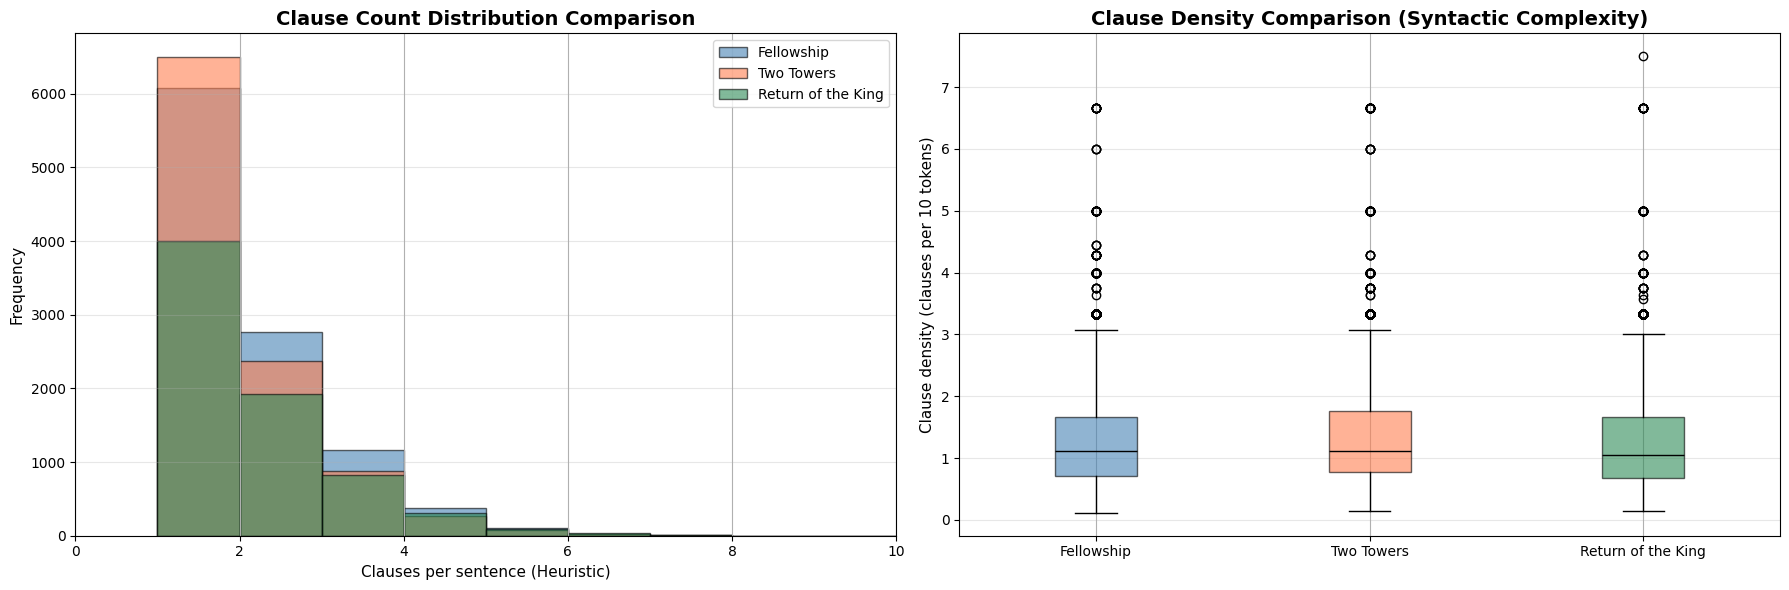

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
book_names = [CONFIG['book1_name'], CONFIG['book2_name'], CONFIG['book3_name']]
colors = ['steelblue', 'coral', 'seagreen']
data_counts = [counts1, counts2, counts3]
data_densities = [densities1, densities2, densities3]

# --- Plot 1: Histogram of Clause Counts ---
ax1 = axes[0]
# Determine max count to set a clear bin range
max_clause_count = max(max(c) for c in data_counts) if data_counts else 10
bins = range(1, 10 + 2) # Limit view to 10 for clarity

for i, counts in enumerate(data_counts):
    ax1.hist(counts, bins=bins, alpha=0.6, color=colors[i], label=book_names[i], edgecolor='black')

ax1.set_xlabel('Clauses per sentence (Heuristic)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Clause Count Distribution Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xlim(0, 10) # Focus on the main distribution

# --- Plot 2: Box Plot Comparison (Clause Density) ---
ax2 = axes[1]
bp = ax2.boxplot(data_densities, tick_labels=book_names, patch_artist=True)

# Color the box plots
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.6)
    # Also color the median lines for better visibility
    bp['medians'][i].set_color('black')

ax2.set_ylabel('Clause density (clauses per 10 tokens)', fontsize=11)
ax2.set_title('Clause Density Comparison (Syntactic Complexity)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig.savefig("../results/clause_density_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

In [4]:
import pandas as pd

# Create a dictionary for the DataFrame
stats_data = {
    'Metric': [
        'Avg clauses per sentence',
        'Avg clause density (per 10 tokens)',
        'Max clauses in one sentence',
        'Sentences with 3+ clauses'
    ],
    CONFIG['book1_name']: [
        avg_clauses1,
        avg_density1,
        np.max(counts1),
        sum(1 for c in counts1 if c >= 3)
    ],
    CONFIG['book2_name']: [
        avg_clauses2,
        avg_density2,
        np.max(counts2),
        sum(1 for c in counts2 if c >= 3)
    ],
    CONFIG['book3_name']: [
        avg_clauses3,
        avg_density3,
        np.max(counts3),
        sum(1 for c in counts3 if c >= 3)
    ]
}

# Create and format the DataFrame
df_stats = pd.DataFrame(stats_data).set_index('Metric')

# Format for readability (using transposed view)
df_formatted = df_stats.T.style.format({
    'Avg clauses per sentence': '{:,.2f}',
    'Avg clause density (per 10 tokens)': '{:,.2f}',
    'Max clauses in one sentence': '{:,.0f}',
    'Sentences with 3+ clauses': '{:,.0f}'
})

print("\n" + "="*70)
print("STATISTICAL COMPARISON")
print("="*70)

# Save table to CSV
df_stats.to_csv("../results/clause_stats_comparison.csv")
print("Saved stats table to ../results/clause_stats_comparison.csv")

# Display the formatted table
df_formatted


STATISTICAL COMPARISON
Saved stats table to ../results/clause_stats_comparison.csv


Metric,Avg clauses per sentence,Avg clause density (per 10 tokens),Max clauses in one sentence,Sentences with 3+ clauses
Fellowship,1.65,1.27,9,"1,687"
Two Towers,1.54,1.39,9,"1,268"
Return of the King,1.71,1.26,8,"1,274"
